In [1]:
import torch
import traceback
import torch_scatter
import yaml
import os
import time
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
import random
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from torch import nn
from scene import Scene, LargeScene
from scene.datasets import GSDataset
from scene import GaussianModel, GaussianModelVoxV2
from gaussian_renderer import render, render_v2
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim
from utils.camera_utils import loadCam
from utils.general_utils import build_rotation, build_symmetric
from pytorch3d.transforms import matrix_to_quaternion

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

## 1. Voxelization

In [3]:
config = '../config/vox_mc_aerial_block9_avg_half.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.pretrain_path = os.path.join("../", lp.pretrain_path)
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    modules = __import__('scene')
    model_config = lp.model_config
    gaussians = getattr(modules, model_config['name'])(lp.sh_degree, **model_config['kwargs'])
    # scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    scene = LargeScene(lp, gaussians, shuffle=False)
    print(f'Loaded {lp.model_path}\n')

Reading camera 1689/1689
Loaded ../output/vox_mc_aerial_block9_avg_half



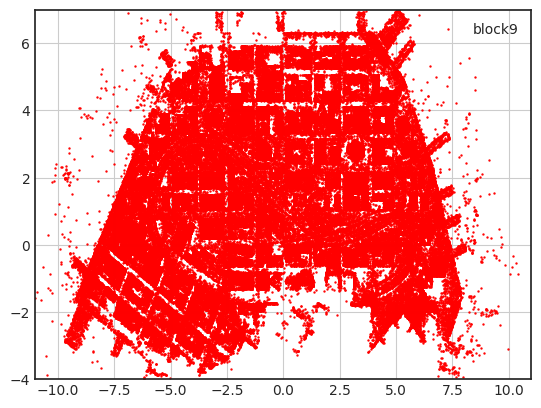

In [5]:
plt.figure()
plt.style.use('seaborn-white')
plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
plt.xlim(-11, 11)
plt.ylim(-4, 7)
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Render time: 0.0394s
L1 Loss: 0.049331169575452805


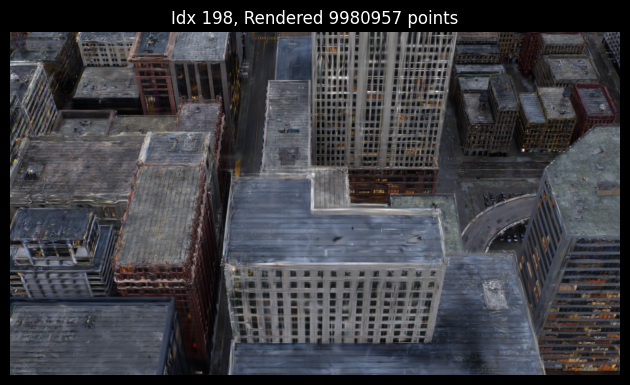

In [26]:
views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
with torch.no_grad():
    idx = random.randint(0, len(views)-1)
    # block3, 126, 0.04370592534542084
    # block3, 163, 0.05137287825345993
    # block3, 111, 0.03362860530614853
    # block3, 95, 0.022822916507720947
    # block3, 160, 0.04986819997429848

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    viewpoint_cam = loadCam(lp, id, views[idx], 1.0)

    start = time.time()
    render_pkg = render(viewpoint_cam, gaussians, pp, background)
    end = time.time()
    print(f'Render time: {end-start:.4f}s')
    image = render_pkg["render"]
    gt_image = viewpoint_cam.original_image.cuda()
    from utils.loss_utils import l1_loss
    Ll1 = l1_loss(image, gt_image)
    print(f'L1 Loss: {Ll1}')

    image = image.cpu().numpy().transpose(1,2,0)
    
    plt.imshow(image)
    plt.title(f"Idx {idx}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()